In [59]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

Загрузим данные на каких будем тренироваться и тестировать

In [60]:
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)

Files already downloaded and verified


In [61]:
image, label = train_dataset[0]
print(image.size())
print(label)

torch.Size([3, 32, 32])
6


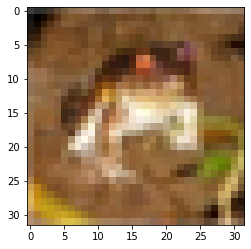

In [62]:
plt.imshow(image.permute(1, 2, 0).numpy())

In [63]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [64]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [65]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
                                          shuffle=False)

In [66]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Создадим класс для нашей модели и предусмотрим возможность менять параметры модели через входящие параметры:
- количество скрытых слоёв
- количество входящих нейронов
- количество нейронов на скрытом слое (по сути это коэфициент, на каждом слое будет разное количество нейронов)
- количество нейронов на выходном слое

In [67]:
class Net(nn.Module):
    def __init__(self, count_hidden, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc = nn.ModuleList()

        self.fc.append(nn.Linear(input_dim, count_hidden * hidden_dim))

        for index in range(count_hidden - 1, 0, -1):
          self.fc.append(nn.Linear((index + 1) * hidden_dim, index * hidden_dim))

        self.fc.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        for fc in self.fc:
          x = fc(x)
          x = F.leaky_relu(x)

        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        
        for fc in self.fc:
          x = fc(x)
          x = F.leaky_relu(x)

        x = F.softmax(x)
        return x

Вынесем постоянные параметры сети в константы и напишем функцию которая будет принимать на вход параметры для обучения

In [68]:
INPUT_DIM = 3 * 32 * 32
OUTPUT_DIM = len(classes)
NUM_EPOCHS = 10 

best_params = {}
best_accuracy = 0

# сюда будем собирать аналитику качества по каждому параметру при одинаковых других параметрах 
analytics = {"num_hidden_layers": {}, "hidden_dim": {}, "fn_optim": {}, "lr": {}}

In [69]:
def search(num_hidden_layers, hidden_dim, fn_optim, lr):
  global best_accuracy
  global best_params
  global analytics

  print("/-----------------------------------------------------------------------------/")
  print(f"hiddenLayers: {num_hidden_layers}")
  print(f"hiddenDim: {hidden_dim}")
  print(f"fn_optim: {str(fn_optim)}")
  print(f"lr: {lr}")
  print()

  net = Net(num_hidden_layers, INPUT_DIM, hidden_dim, OUTPUT_DIM)
  net.train()

  criterion = nn.CrossEntropyLoss()
  optimizer = fn_optim(net.parameters(), lr=lr)

  for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    running_items = 0.0


    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

         # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)

    print(f"Epoch [{epoch + 1}]: Loss: {running_loss / running_items:.3f}")
    running_loss, running_items = 0.0, 0.0

  print('Training is finished!')

  data_iter = iter(test_loader)
  images, labels = data_iter.next()

  net.eval()
  outputs = net(images)

  _, predicted = torch.max(outputs, 1)

  gt = np.array([classes[labels[j]] for j in range(len(labels))])
  pred = np.array([classes[predicted[j]] for j in range(len(labels))])
  accuracy = (gt == pred).sum() / len(gt)

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_params = {"hiddenLayers": num_hidden_layers, "hiddenDim": hidden_dim, "fn_optim": str(fn_optim), "lr": lr}

  print(gt)
  print(pred)
  print(f'Accuracy is {accuracy}')

  # собираем аналитику
  key_for_num_hidden_layers = f"{hidden_dim}-{str(fn_optim)}-{lr}"
  key_for_hidden_dim = f"{num_hidden_layers}-{str(fn_optim)}-{lr}"
  key_for_fn_optim = f"{num_hidden_layers}-{hidden_dim}-{lr}"
  key_for_lr = f"{num_hidden_layers}-{hidden_dim}-{str(fn_optim)}"
  
  if key_for_num_hidden_layers not in analytics["num_hidden_layers"]:
      analytics["num_hidden_layers"][key_for_num_hidden_layers] = {
          "params": {"hidden_dim": hidden_dim, "fn_optim": str(fn_optim), "lr": lr},
          "accuracies": []
      }
  
  if key_for_hidden_dim not in analytics["hidden_dim"]:
      analytics["hidden_dim"][key_for_hidden_dim] = {
          "params": {"num_hidden_layers": num_hidden_layers, "fn_optim": str(fn_optim), "lr": lr},
          "accuracies": []
      }
      
  if key_for_fn_optim not in analytics["fn_optim"]:
      analytics["fn_optim"][key_for_fn_optim] = {
          "params": {"num_hidden_layers": num_hidden_layers, "hidden_dim": hidden_dim, "lr": lr},
          "accuracies": []
      }
  
  if key_for_lr not in analytics["lr"]:
      analytics["lr"][key_for_lr] = {
          "params": {"num_hidden_layers": num_hidden_layers, "hidden_dim": hidden_dim, "fn_optim": str(fn_optim)},
          "accuracies": []
      }
  
  analytics["hidden_dim"][key_for_hidden_dim]["accuracies"].append(accuracy)
  analytics["fn_optim"][key_for_fn_optim]["accuracies"].append(accuracy)
  analytics["num_hidden_layers"][key_for_num_hidden_layers]["accuracies"].append(accuracy)
  analytics["lr"][key_for_lr]["accuracies"].append(accuracy)

Определим массивы параметров для поиска

In [70]:
hidden_layers = [1, 2, 3, 5]
hidden_dims = [10, 50, 100]
lrs = [0.01, 0.001]
optims = [optim.SGD, optim.Adam, optim.NAdam]

In [71]:
for num_layers in hidden_layers:
  for hidden_dim in hidden_dims:
     for lr in lrs:
       for fn_optim in optims:
         search(num_layers, hidden_dim, fn_optim, lr)

/-----------------------------------------------------------------------------/
hiddenLayers: 1
hiddenDim: 10
fn_optim: <class 'torch.optim.sgd.SGD'>
lr: 0.01

Epoch [1]: Loss: 0.033
Epoch [2]: Loss: 0.030
Epoch [3]: Loss: 0.029
Epoch [4]: Loss: 0.028
Epoch [5]: Loss: 0.028
Epoch [6]: Loss: 0.028
Epoch [7]: Loss: 0.027
Epoch [8]: Loss: 0.027
Epoch [9]: Loss: 0.027
Epoch [10]: Loss: 0.027
Training is finished!
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'truck' 'ship' 'ship' 'deer' 'frog' 'cat' 'frog']
Accuracy is 0.5
/-----------------------------------------------------------------------------/
hiddenLayers: 1
hiddenDim: 10
fn_optim: <class 'torch.optim.adam.Adam'>
lr: 0.01

Epoch [1]: Loss: 0.034
Epoch [2]: Loss: 0.030
Epoch [3]: Loss: 0.029
Epoch [4]: Loss: 0.028
Epoch [5]: Loss: 0.028
Epoch [6]: Loss: 0.028
Epoch [7]: Loss: 0.028
Epoch [8]: Loss: 0.027
Epoch [9]: Loss: 0.027
Epoch [10]: Loss: 0.027
Training is finished!
['cat' 'ship' 'ship' 'plane' 'frog' 'frog'

In [72]:
best_accuracy

0.75

In [73]:
best_params

{'fn_optim': "<class 'torch.optim.nadam.NAdam'>",
 'hiddenDim': 50,
 'hiddenLayers': 1,
 'lr': 0.01}

In [74]:
analytics

{'fn_optim': {'1-10-0.001': {'accuracies': [0.375, 0.625, 0.5],
   'params': {'hidden_dim': 10, 'lr': 0.001, 'num_hidden_layers': 1}},
  '1-10-0.01': {'accuracies': [0.5, 0.5, 0.625],
   'params': {'hidden_dim': 10, 'lr': 0.01, 'num_hidden_layers': 1}},
  '1-100-0.001': {'accuracies': [0.25, 0.625, 0.625],
   'params': {'hidden_dim': 100, 'lr': 0.001, 'num_hidden_layers': 1}},
  '1-100-0.01': {'accuracies': [0.375, 0.125, 0.25],
   'params': {'hidden_dim': 100, 'lr': 0.01, 'num_hidden_layers': 1}},
  '1-50-0.001': {'accuracies': [0.25, 0.375, 0.375],
   'params': {'hidden_dim': 50, 'lr': 0.001, 'num_hidden_layers': 1}},
  '1-50-0.01': {'accuracies': [0.625, 0.25, 0.75],
   'params': {'hidden_dim': 50, 'lr': 0.01, 'num_hidden_layers': 1}},
  '2-10-0.001': {'accuracies': [0.25, 0.625, 0.75],
   'params': {'hidden_dim': 10, 'lr': 0.001, 'num_hidden_layers': 2}},
  '2-10-0.01': {'accuracies': [0.625, 0.125, 0.75],
   'params': {'hidden_dim': 10, 'lr': 0.01, 'num_hidden_layers': 2}},
  '2-1

In [75]:
def show_graph_by_accuracy(accaracies, x_params, x_label, title):
    plt.figure(figsize = (8,5))
    plt.plot(x_params, accaracies)
    plt.xlabel(x_label)
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid()
    plt.show()

Расмотрим результат собранной аналитики

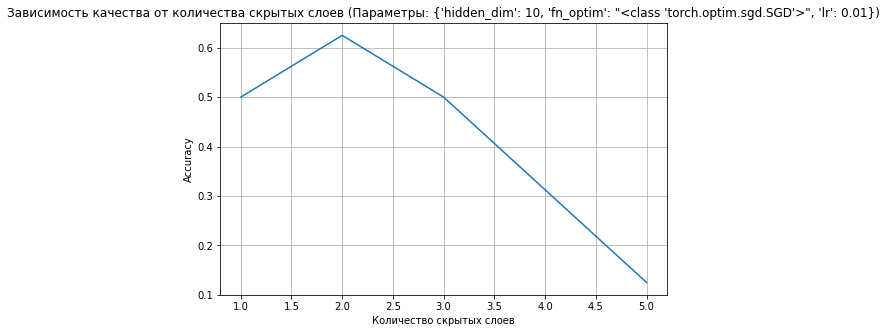

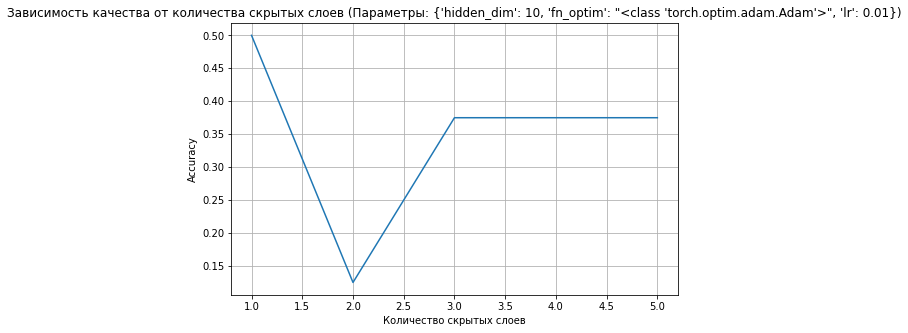

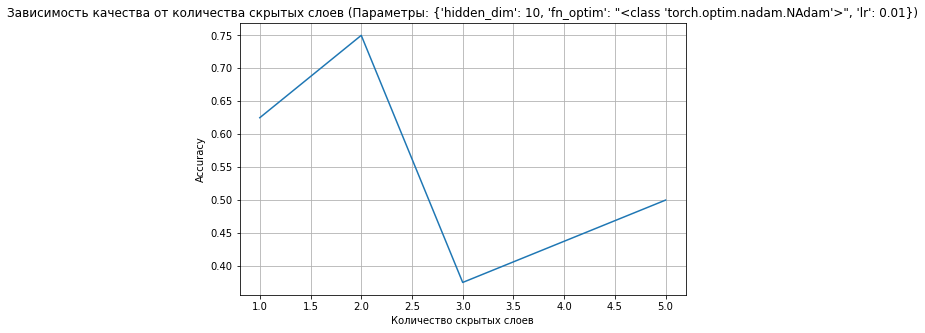

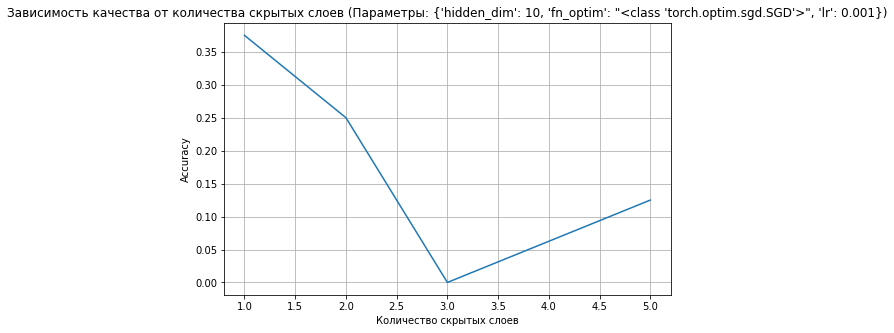

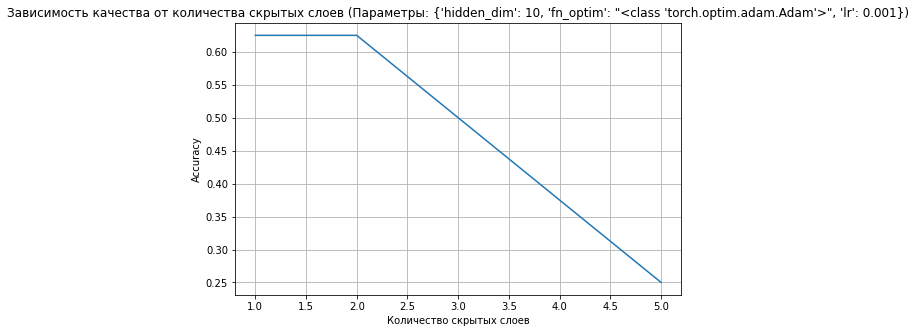

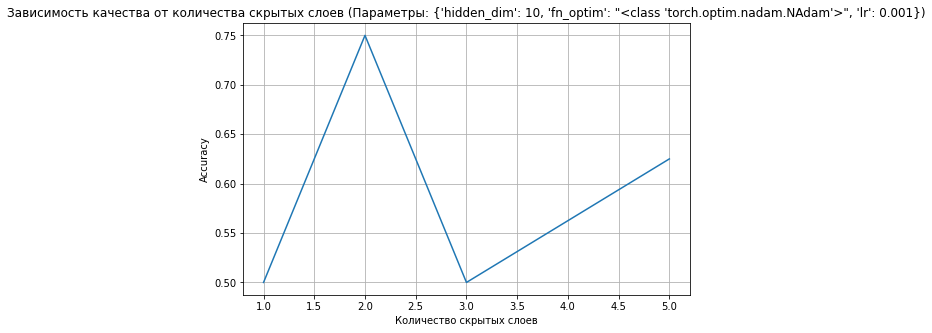

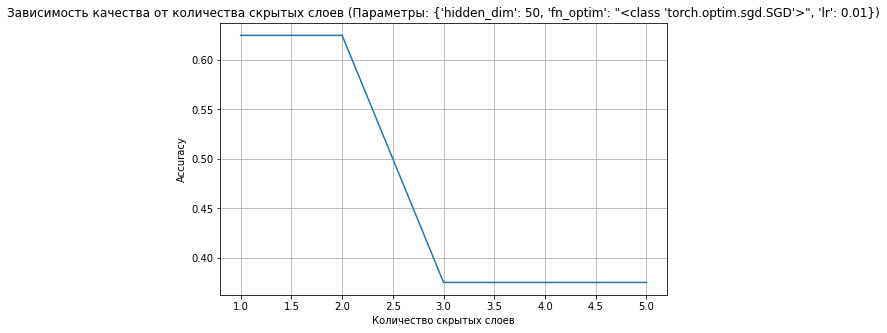

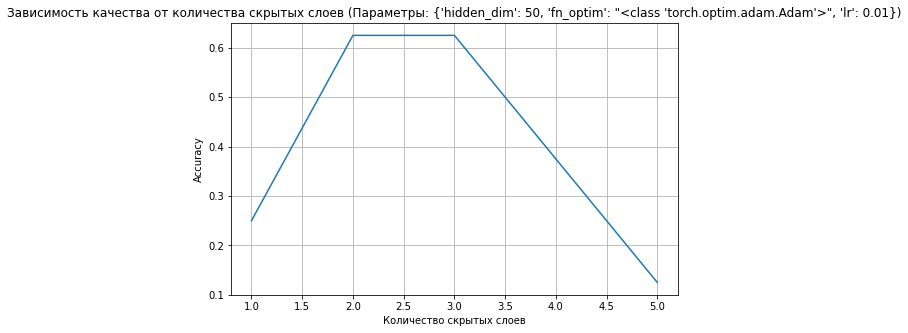

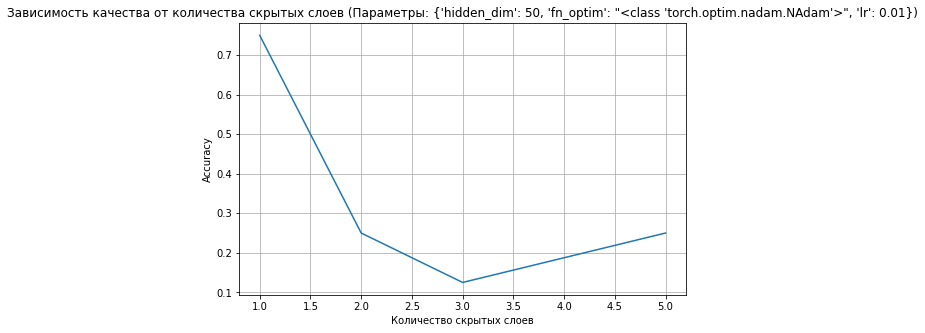

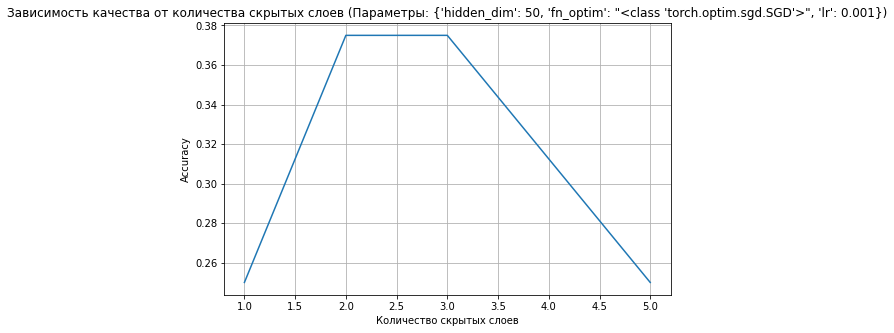

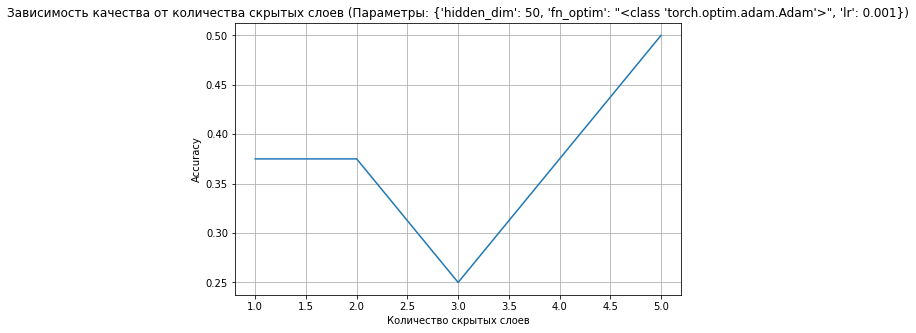

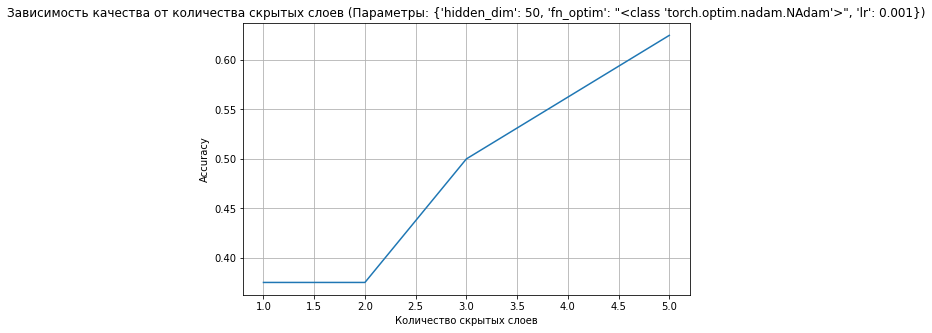

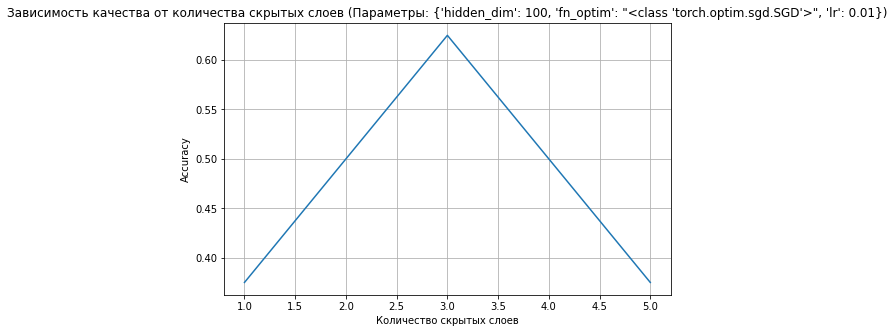

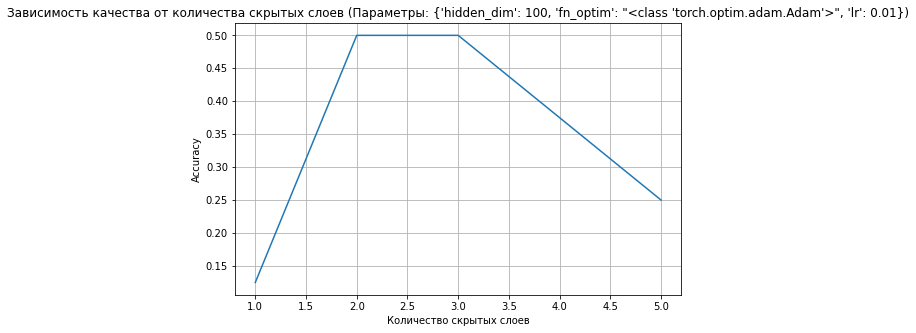

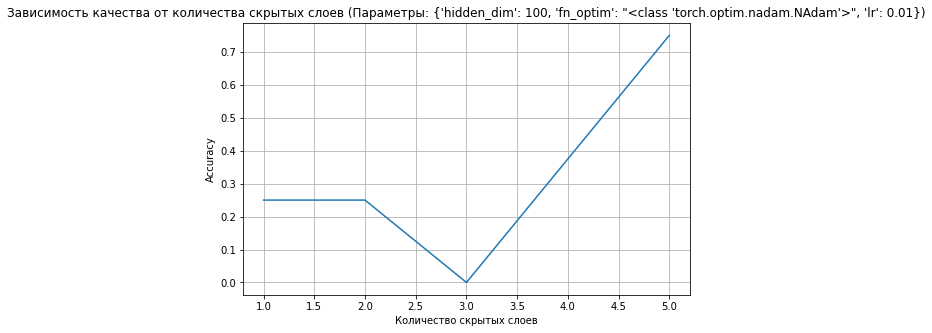

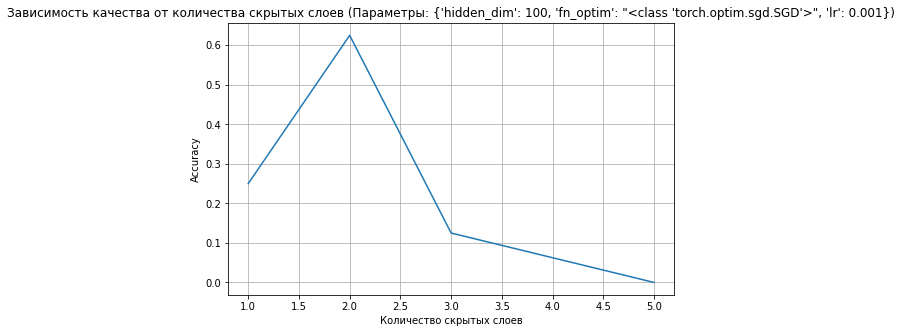

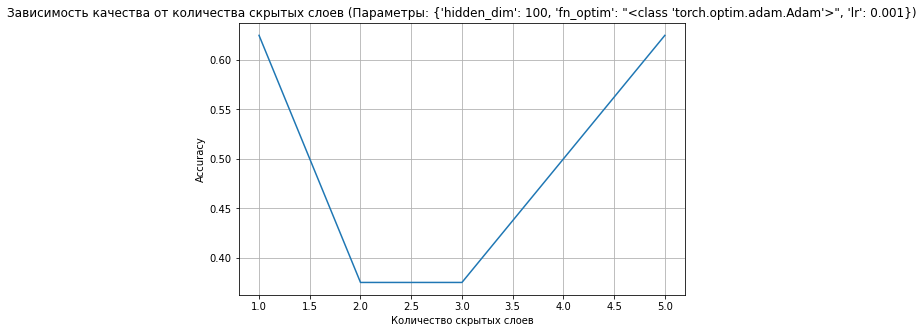

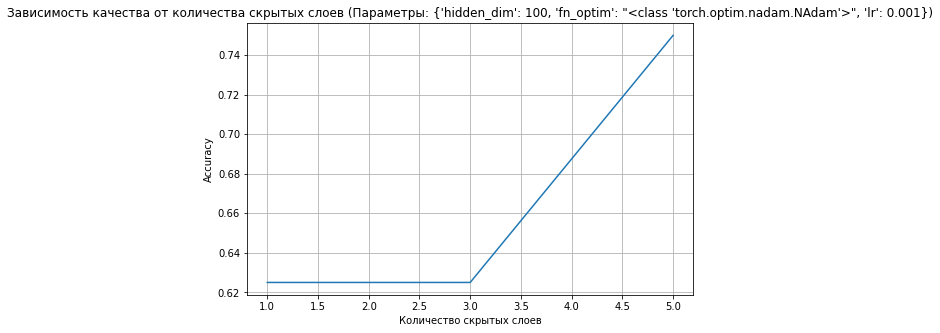

In [76]:
for key in analytics["num_hidden_layers"]:
    num_hidden_layers_analitic = analytics["num_hidden_layers"][key]
    accuracies = num_hidden_layers_analitic["accuracies"]
    params = num_hidden_layers_analitic["params"]
    
    show_graph_by_accuracy(
        accuracies, 
        hidden_layers, 
        "Количество скрытых слоев", 
        f"Зависимость качества от количества скрытых слоев (Параметры: {params})"
    )

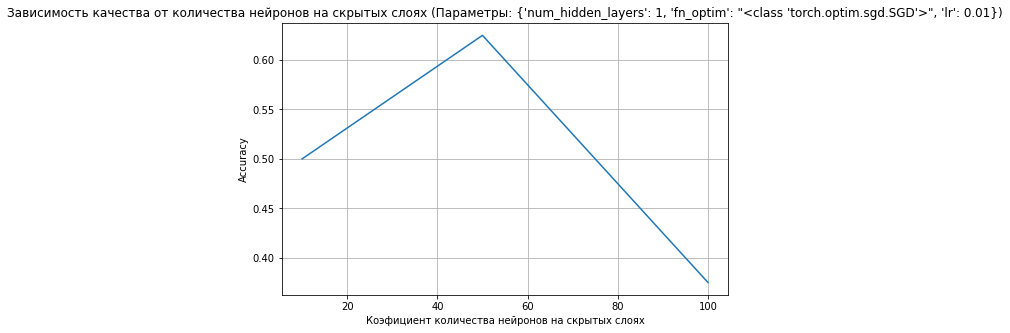

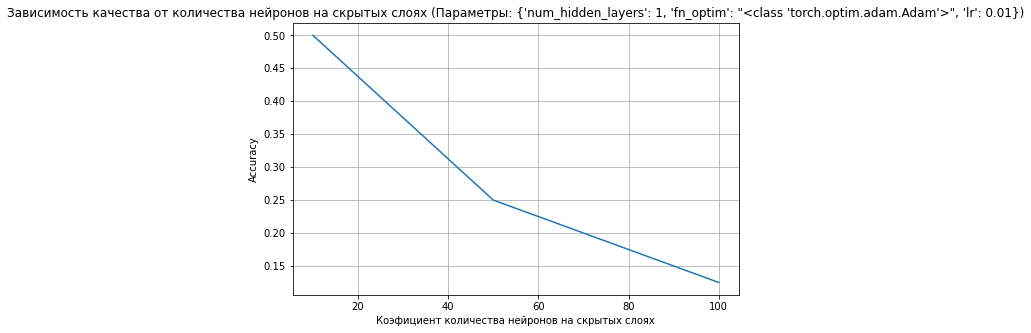

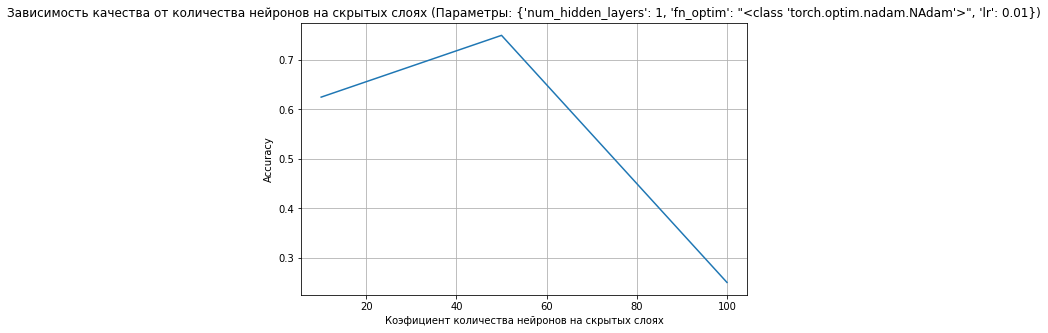

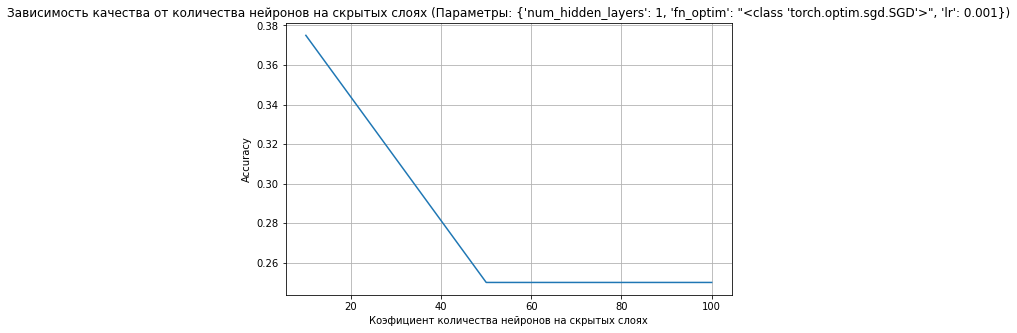

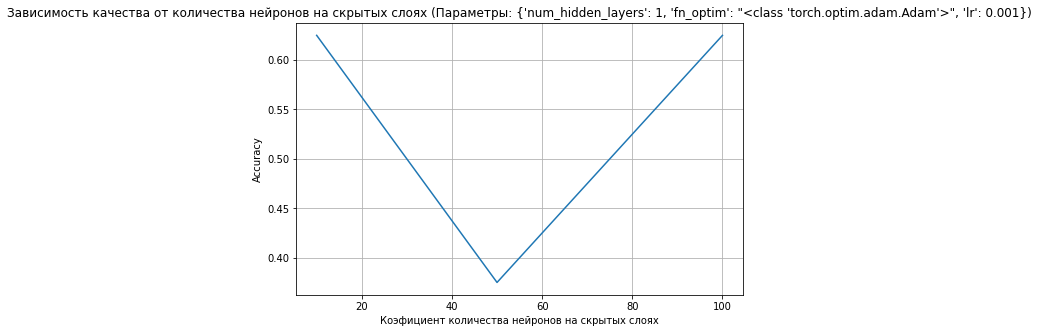

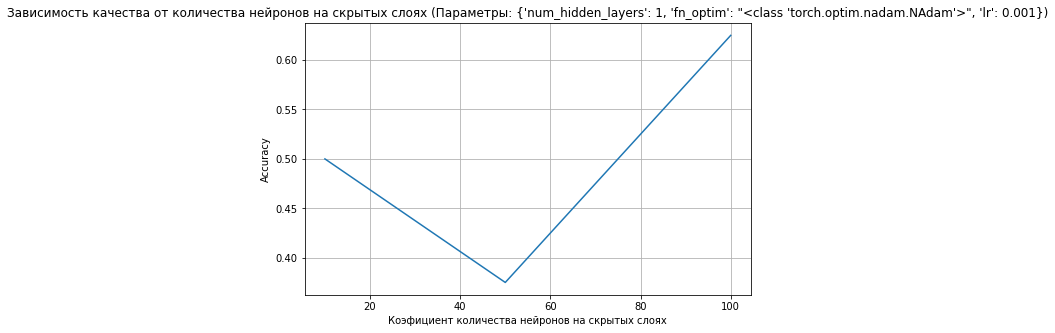

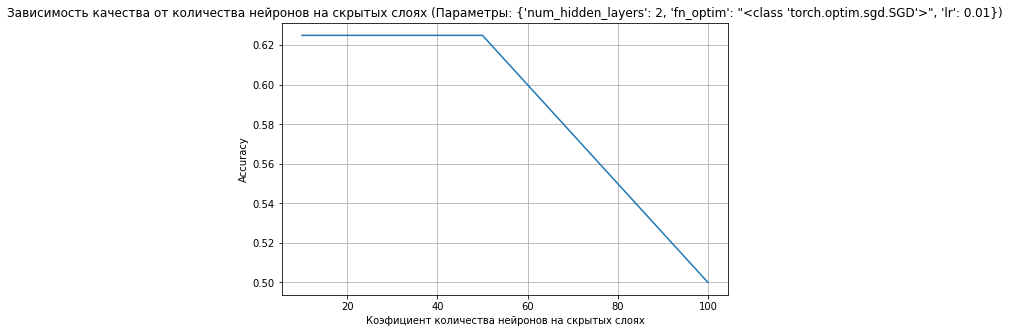

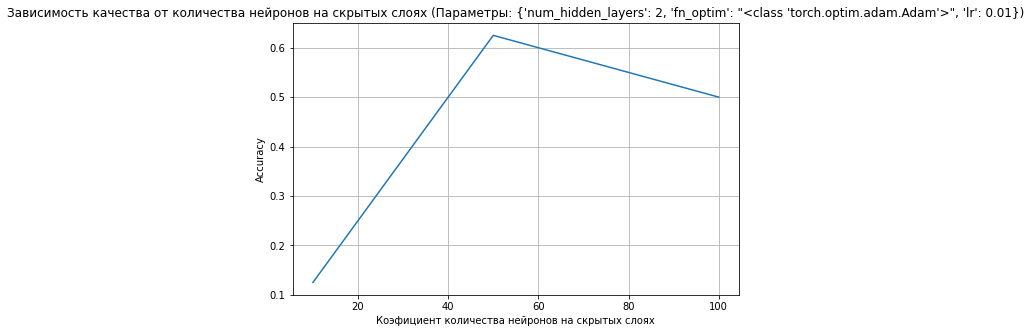

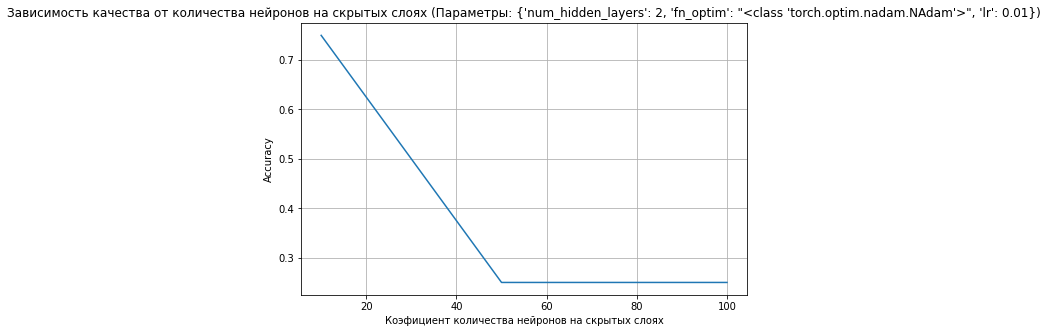

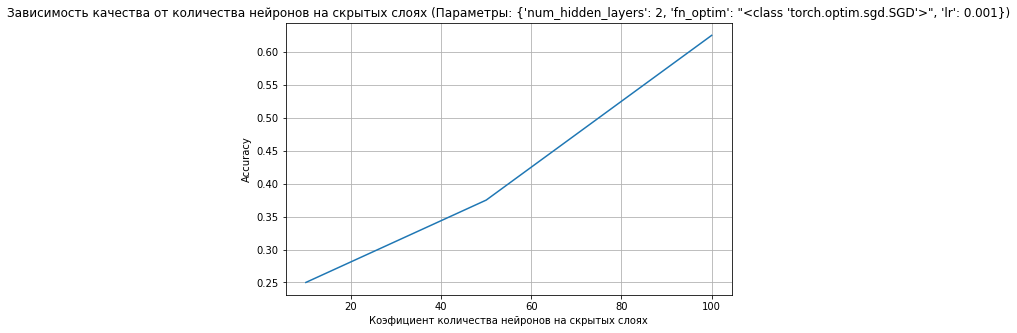

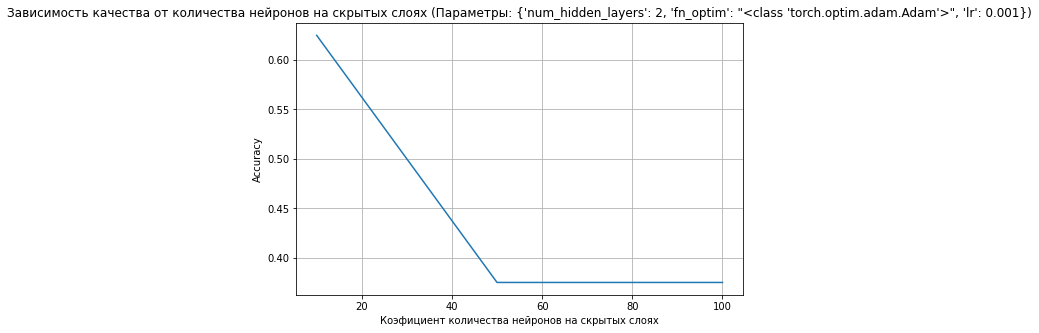

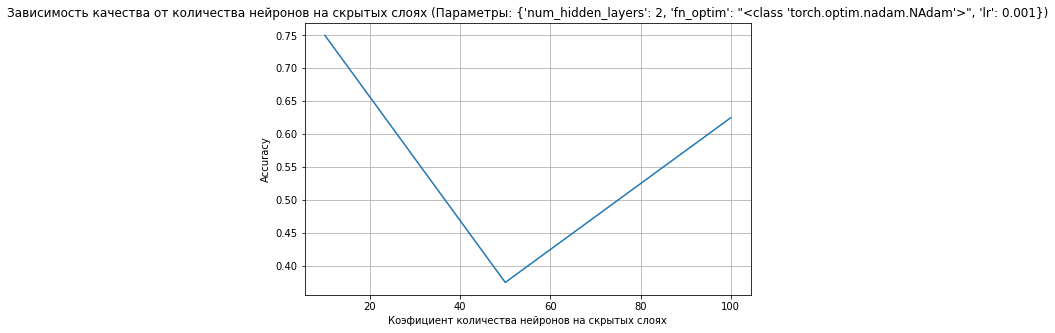

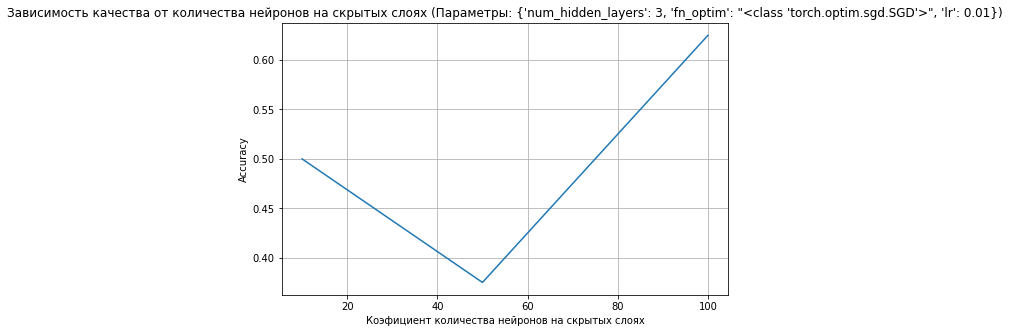

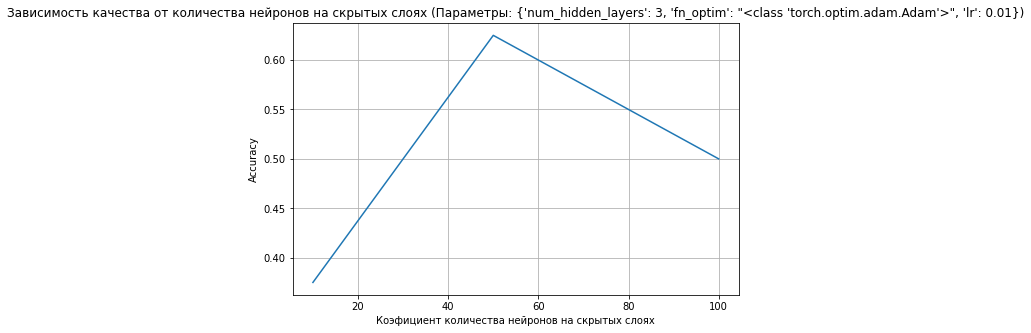

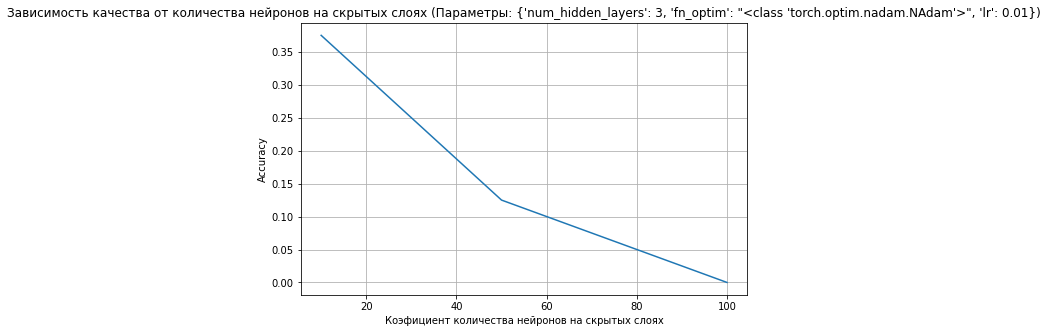

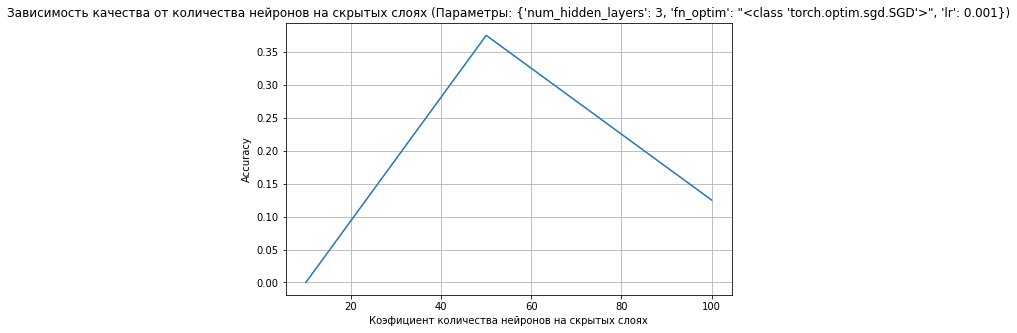

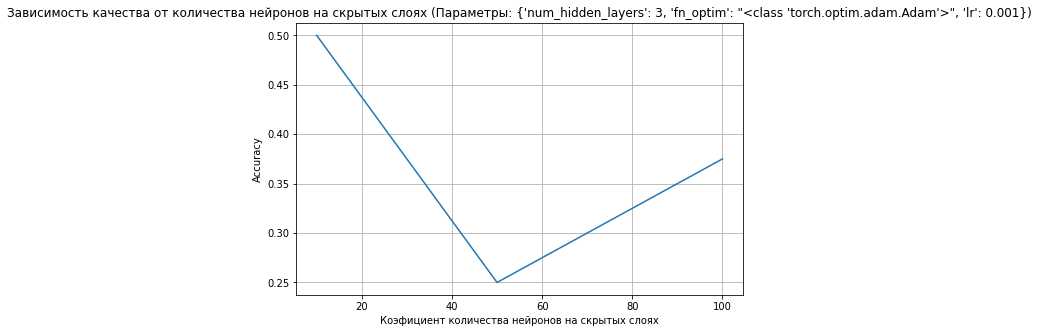

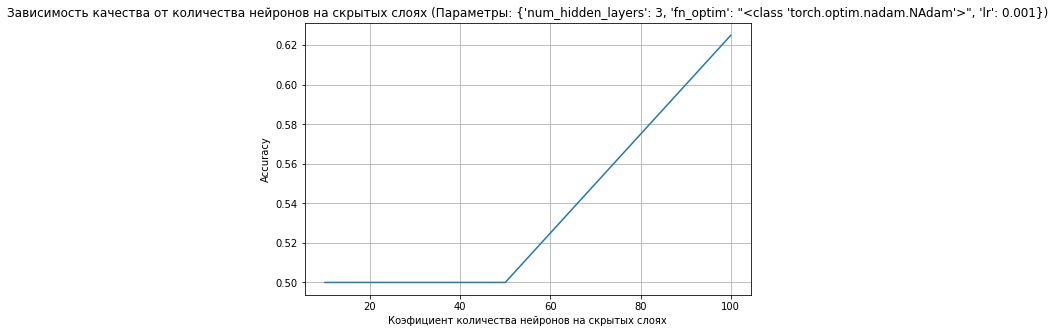

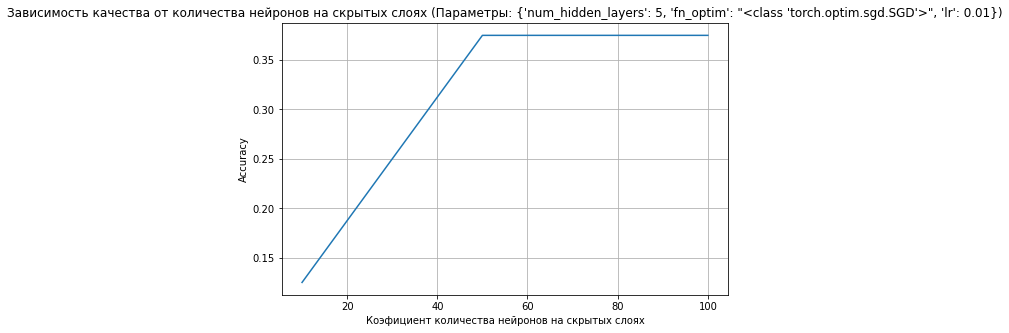

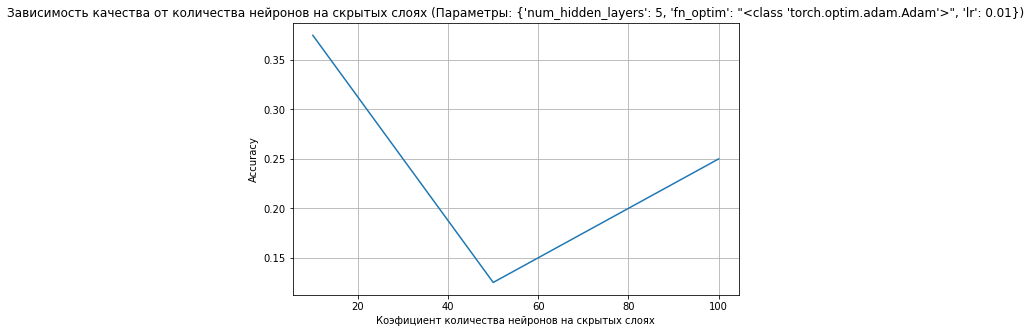

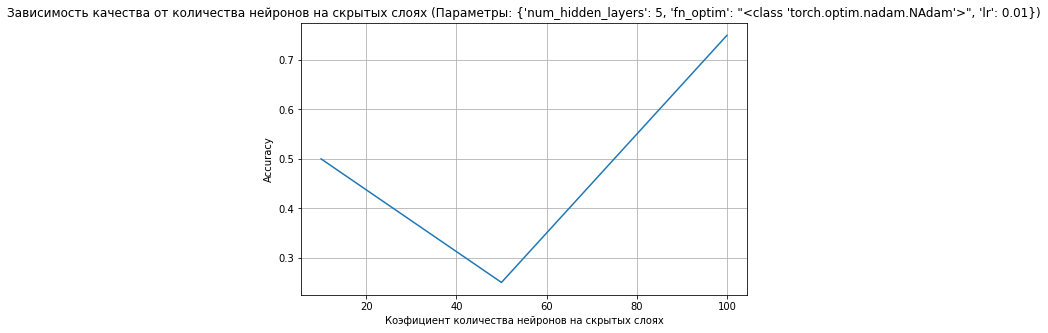

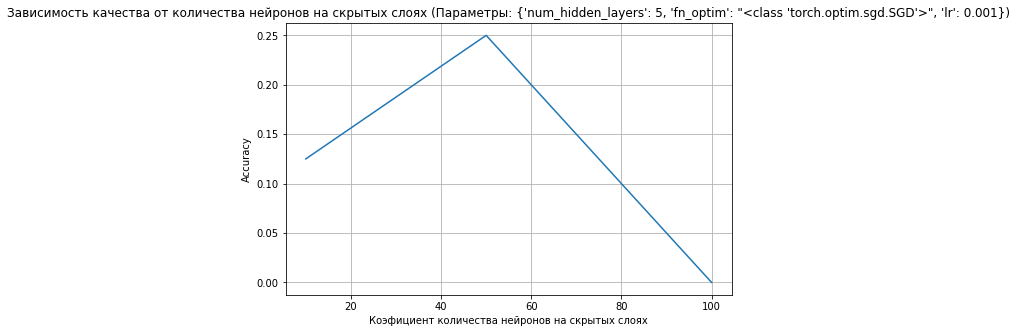

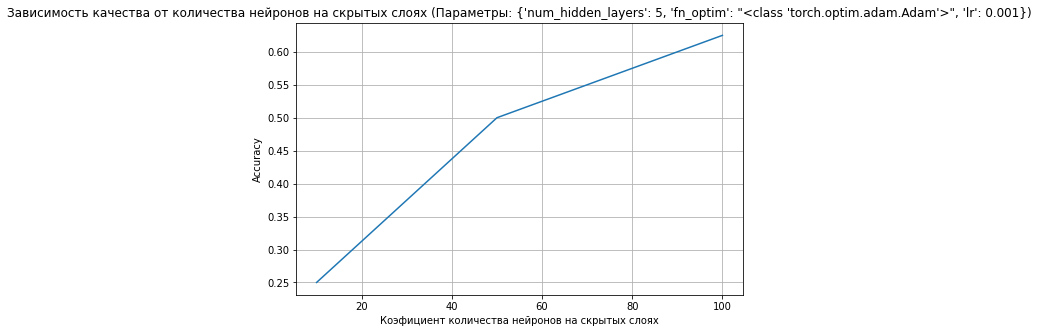

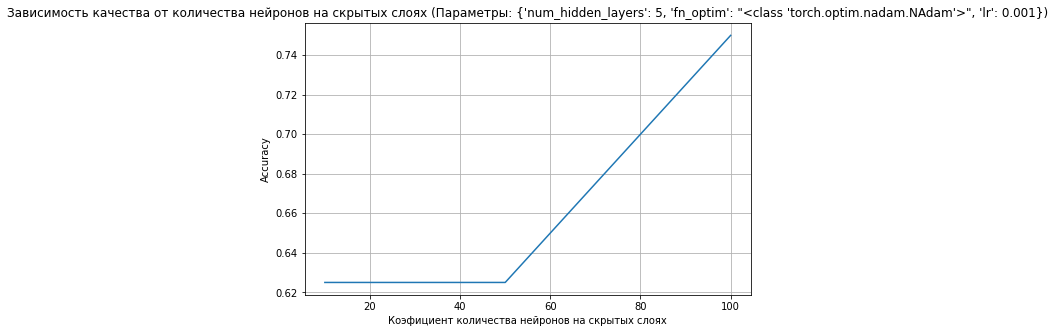

In [77]:
for key in analytics["hidden_dim"]:
    hidden_dim_analitic = analytics["hidden_dim"][key]
    accuracies = hidden_dim_analitic["accuracies"]
    params = hidden_dim_analitic["params"]
    
    show_graph_by_accuracy(
        accuracies, 
        hidden_dims, 
        "Коэфициент количества нейронов на скрытых слоях", 
        f"Зависимость качества от количества нейронов на скрытых слоях (Параметры: {params})"
    )

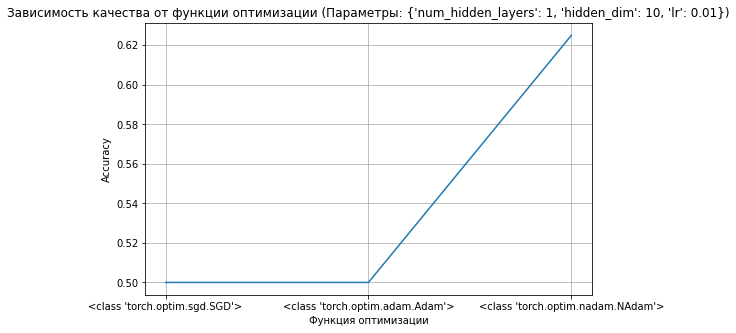

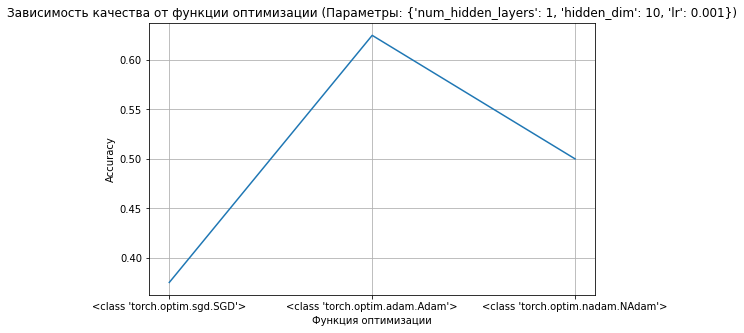

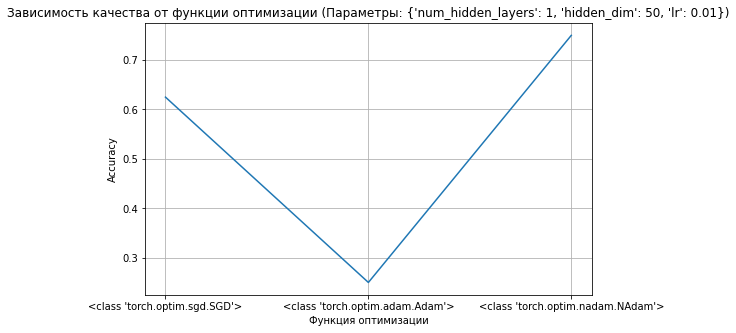

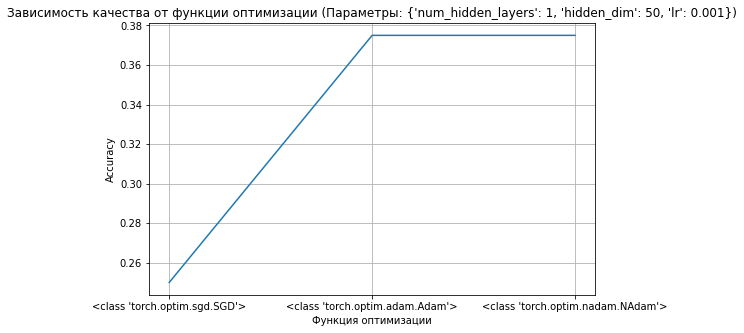

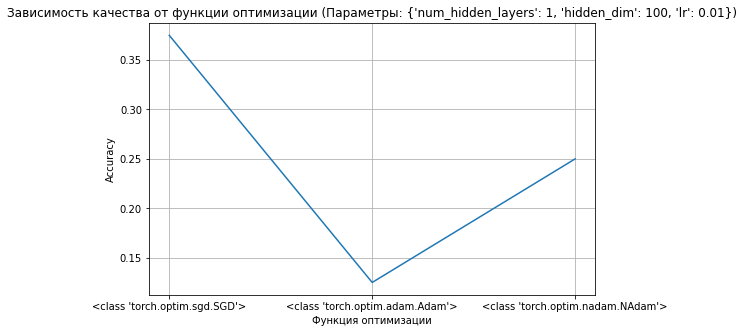

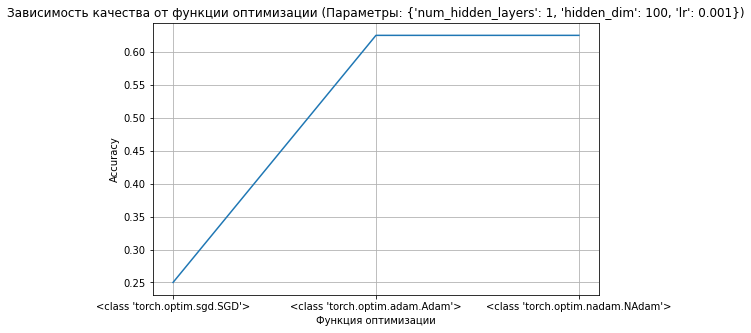

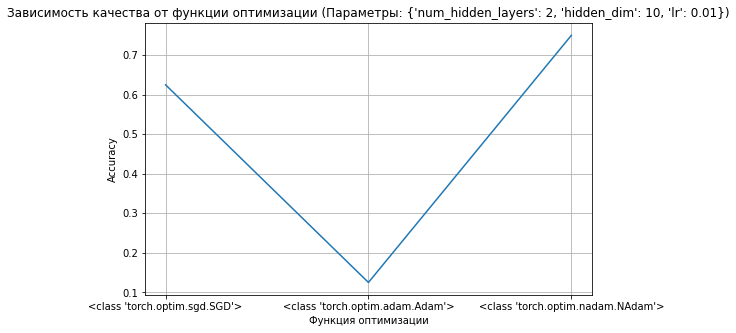

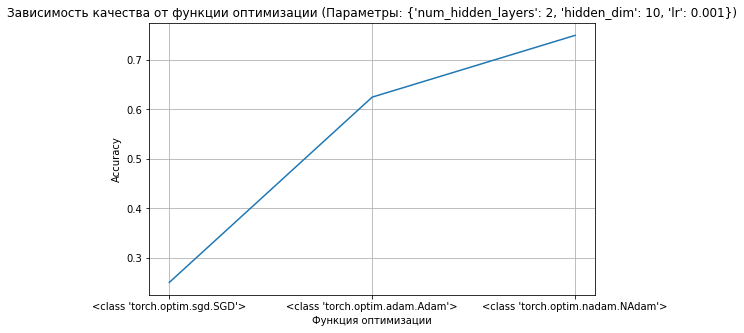

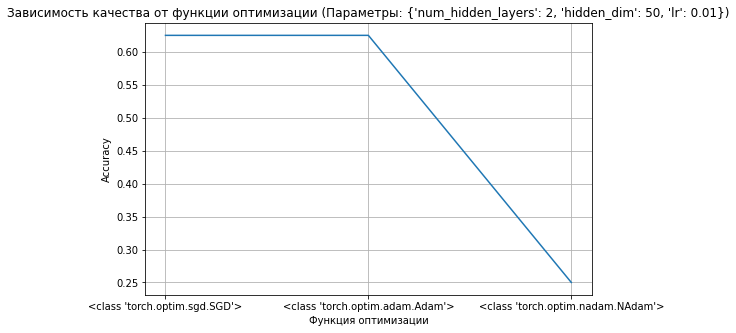

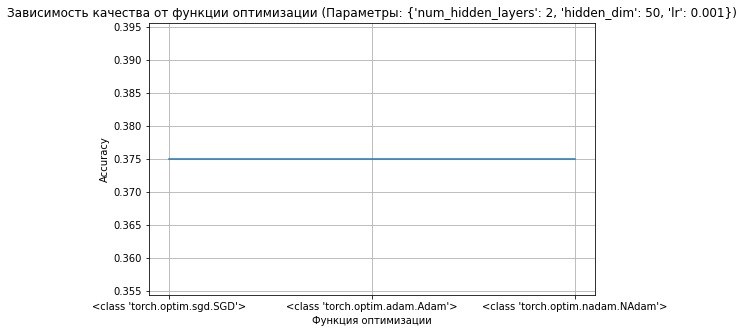

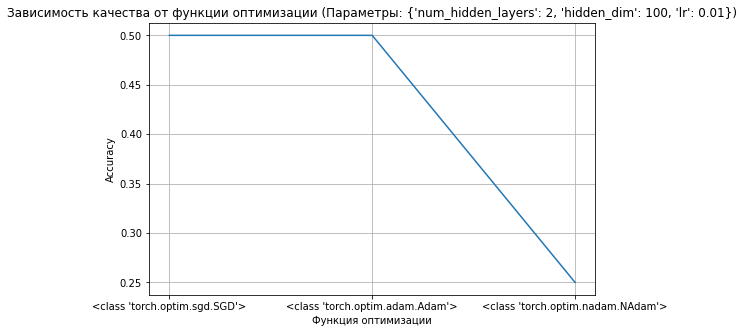

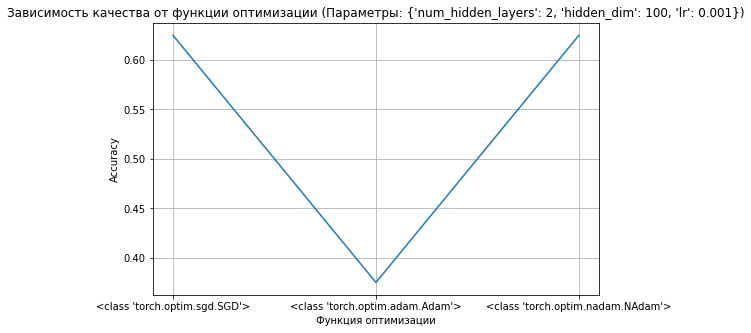

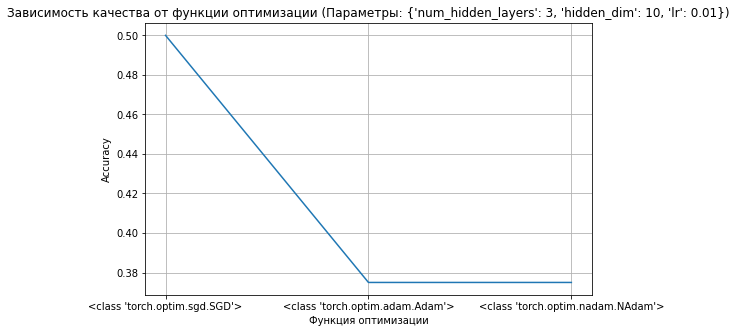

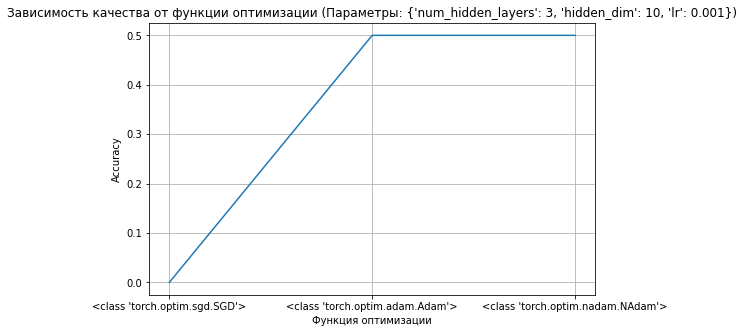

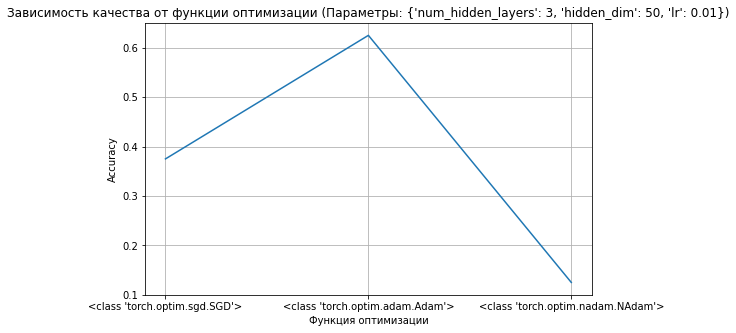

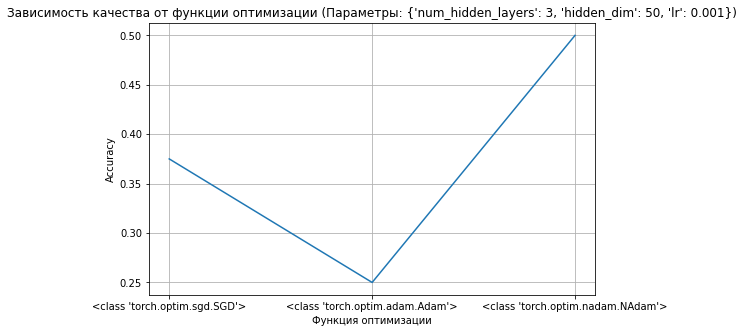

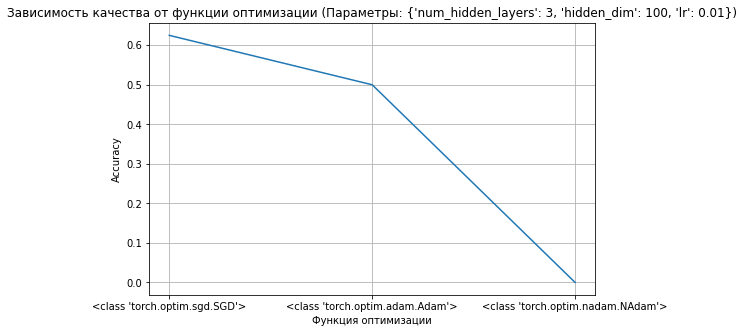

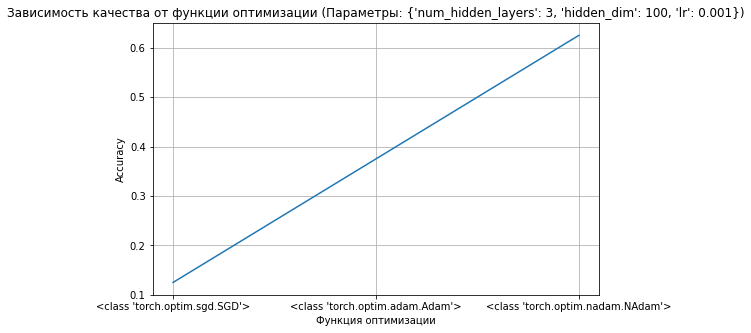

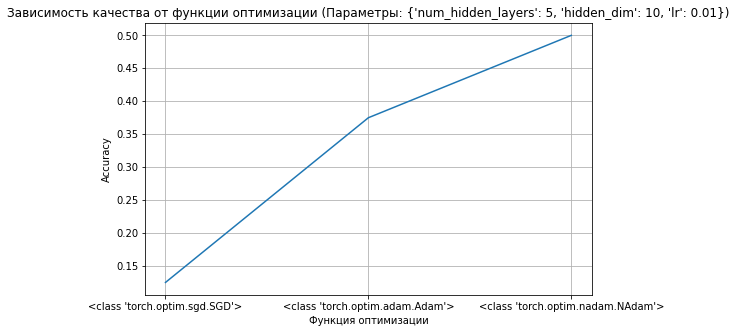

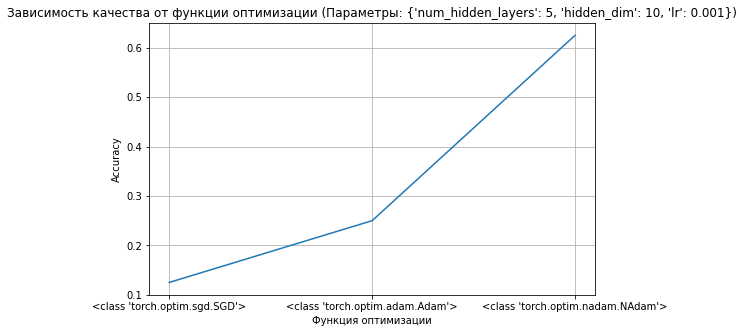

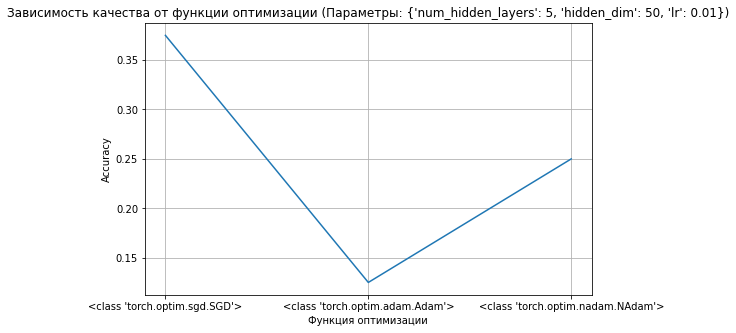

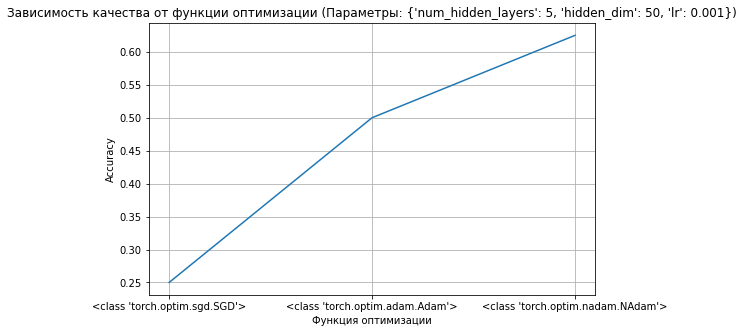

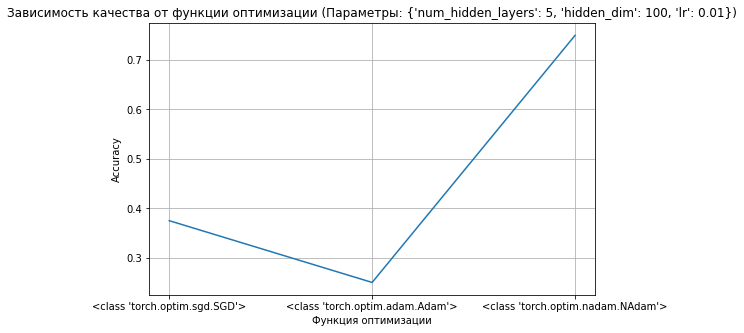

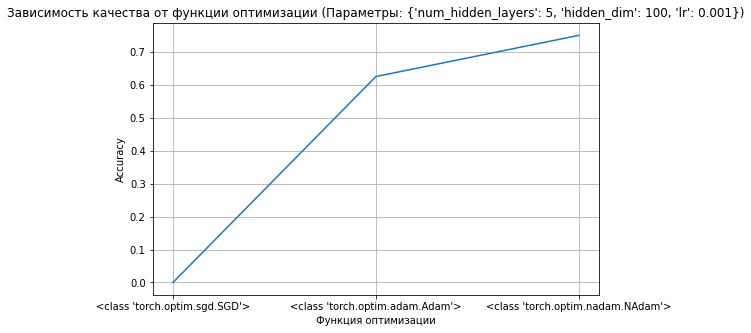

In [78]:
for key in analytics["fn_optim"]:
    optim_analitic = analytics["fn_optim"][key]
    accuracies = optim_analitic["accuracies"]
    params = optim_analitic["params"]
    fn_optims = [str(fn_optim) for fn_optim in optims]
    
    show_graph_by_accuracy(
        accuracies, 
        fn_optims, 
        "Функция оптимизации", 
        f"Зависимость качества от функции оптимизации (Параметры: {params})"
    )

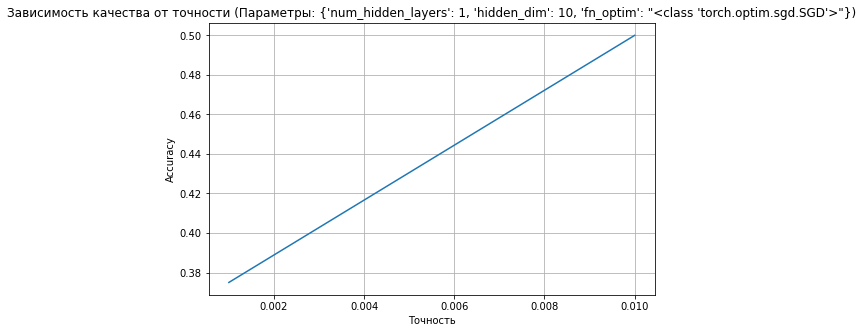

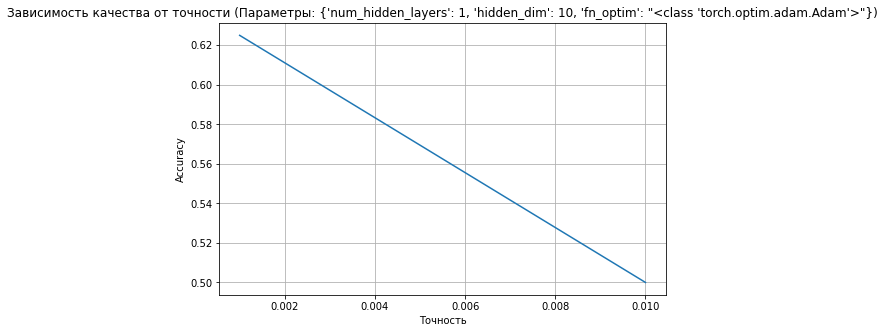

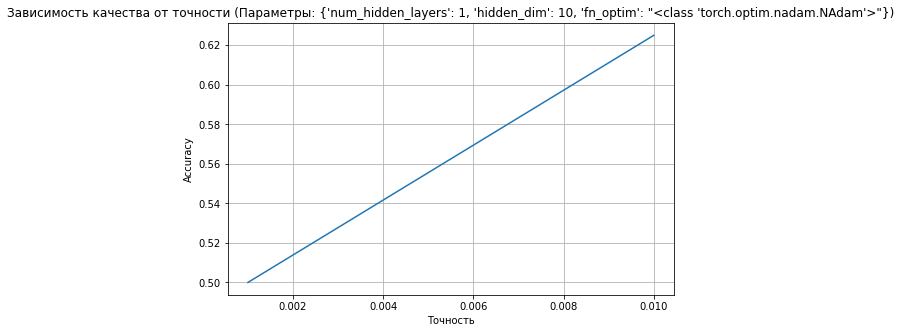

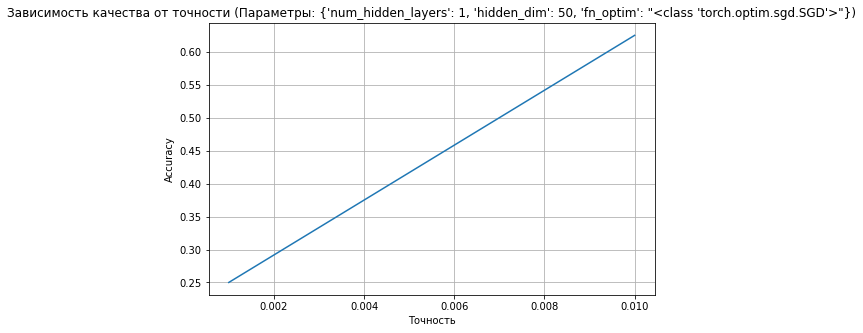

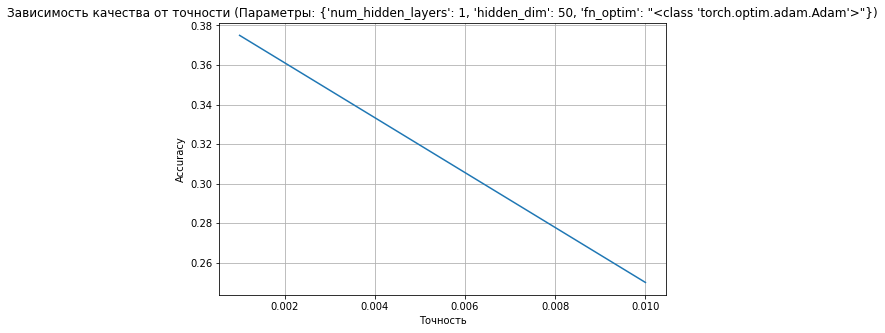

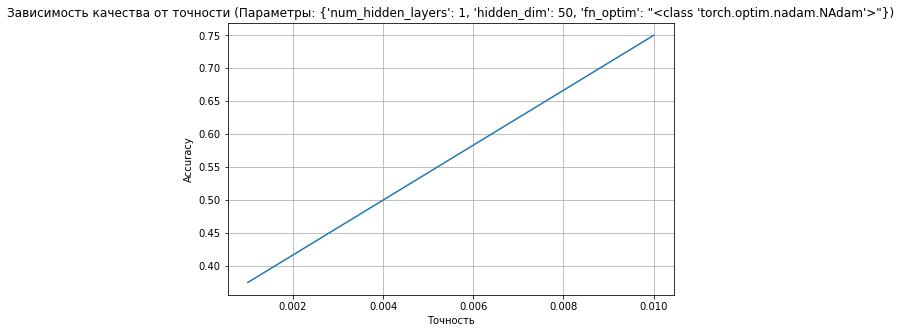

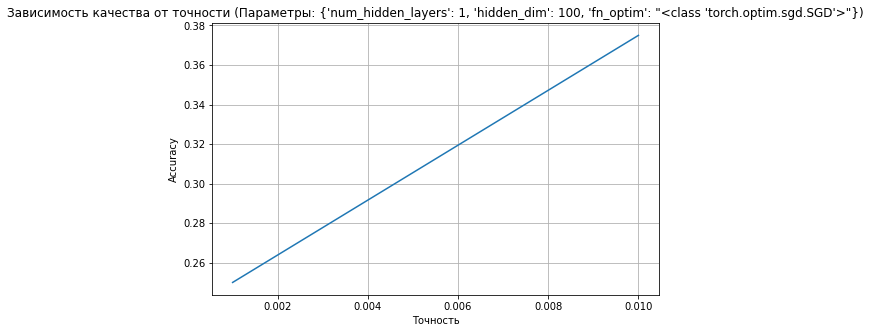

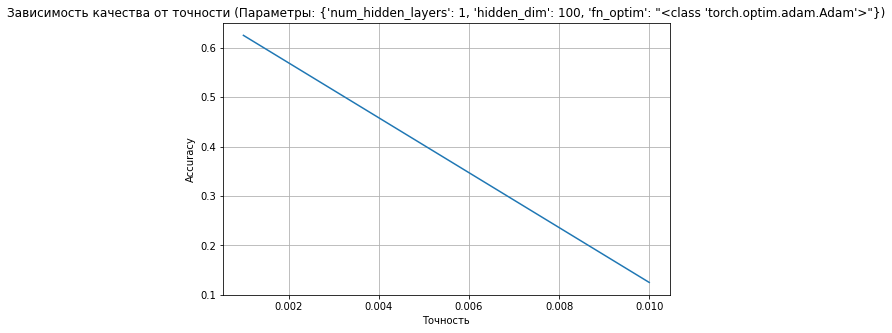

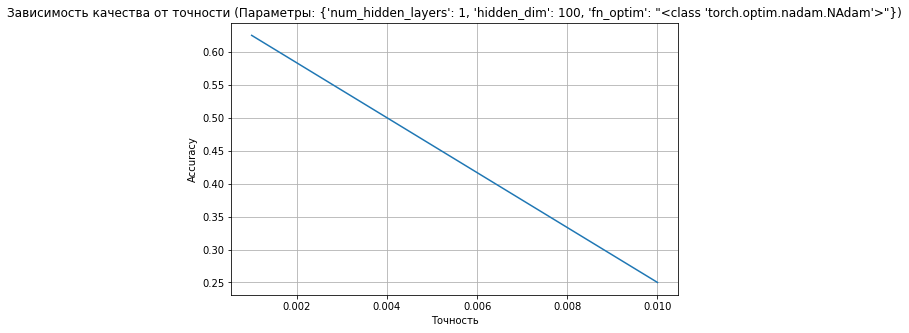

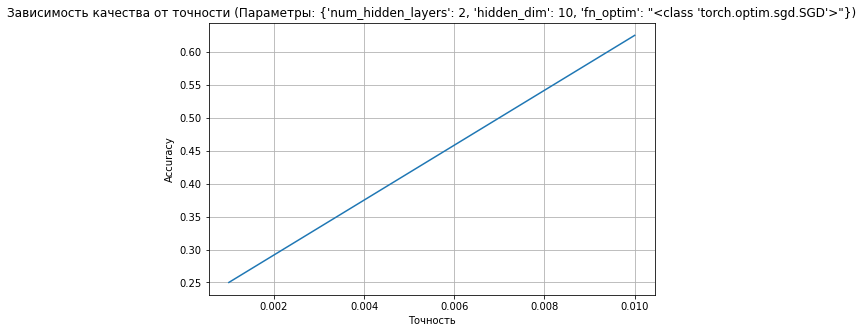

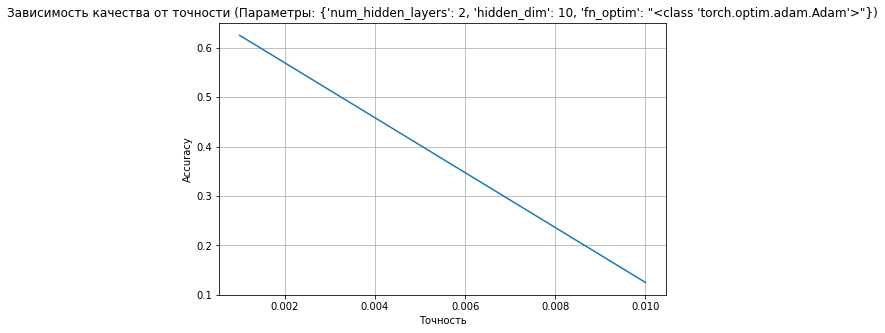

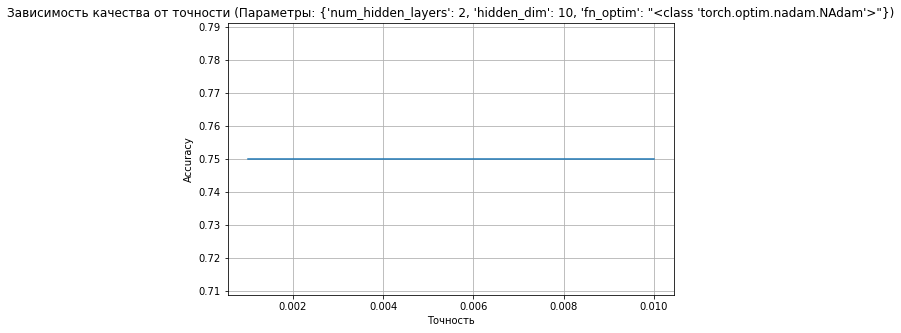

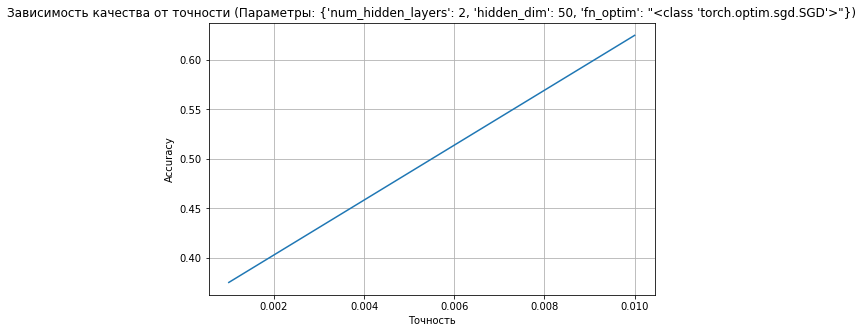

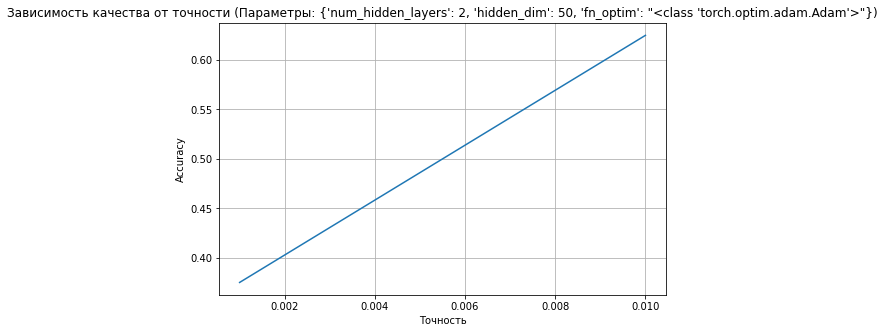

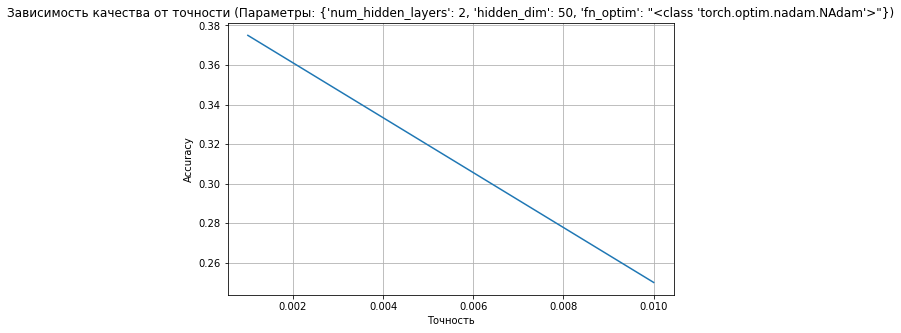

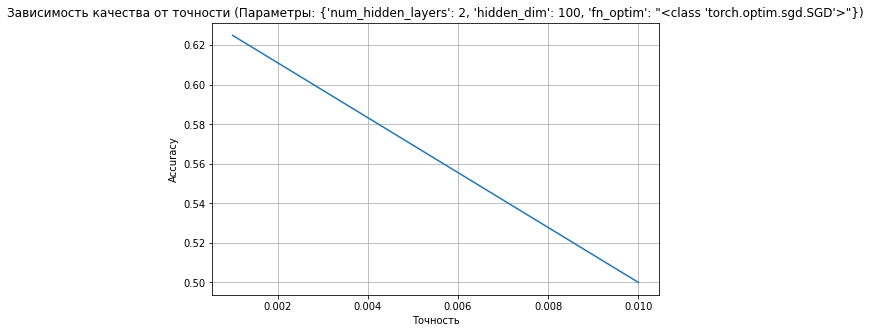

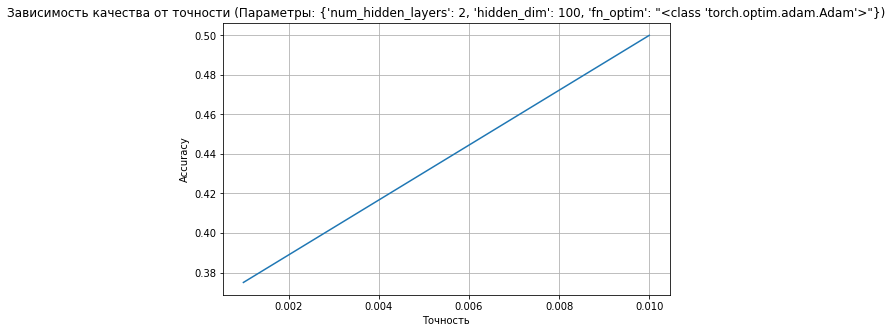

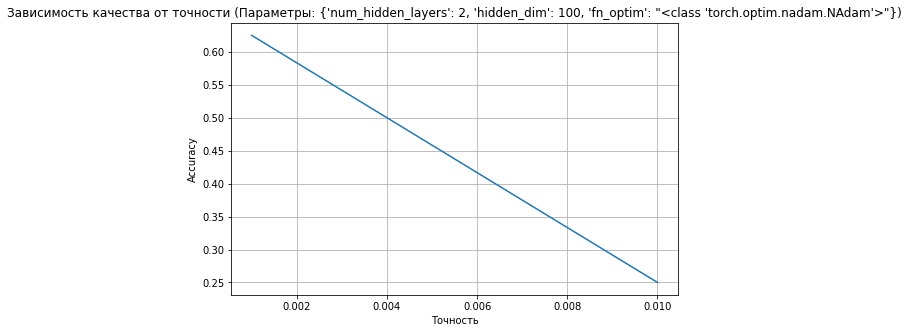

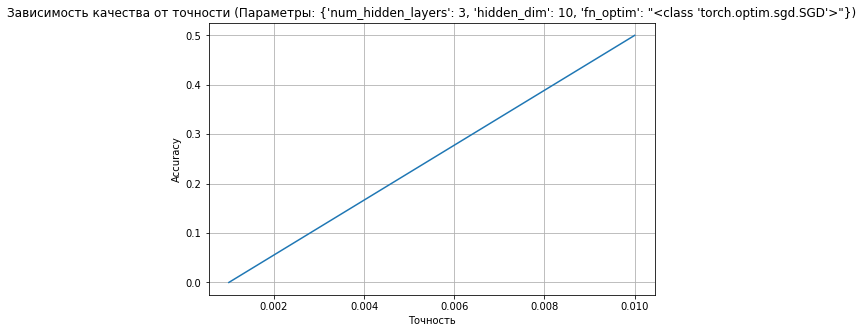

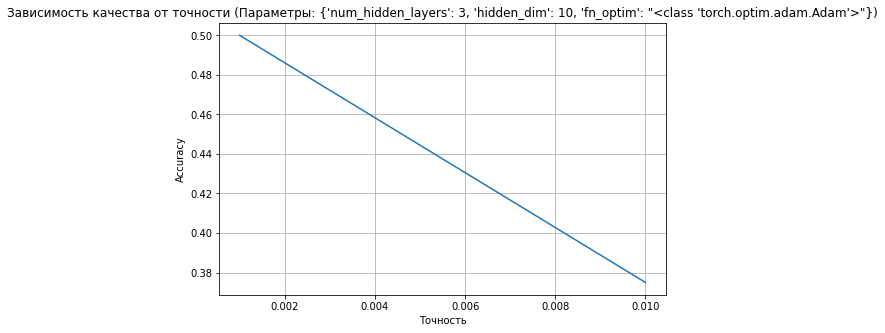

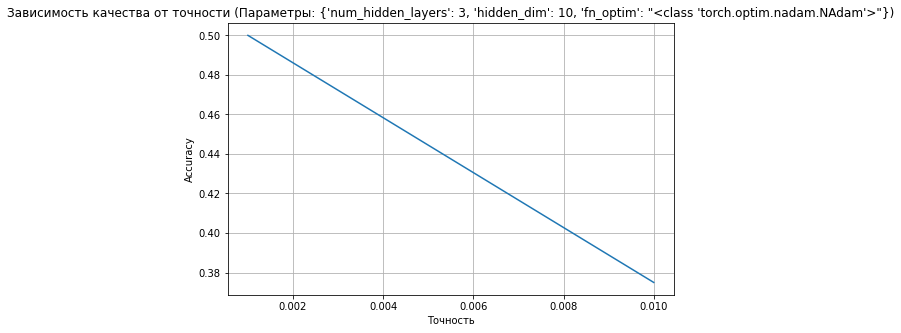

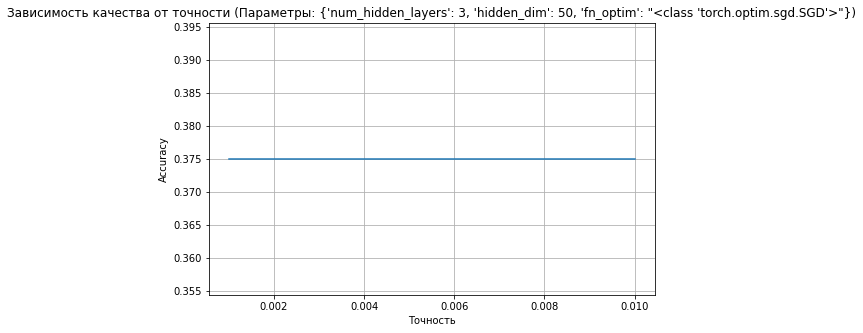

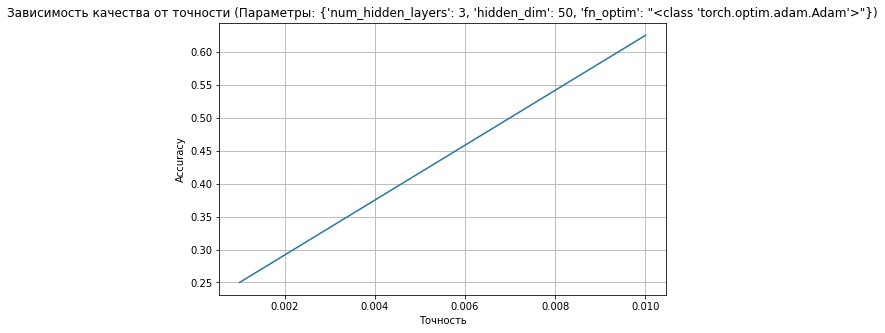

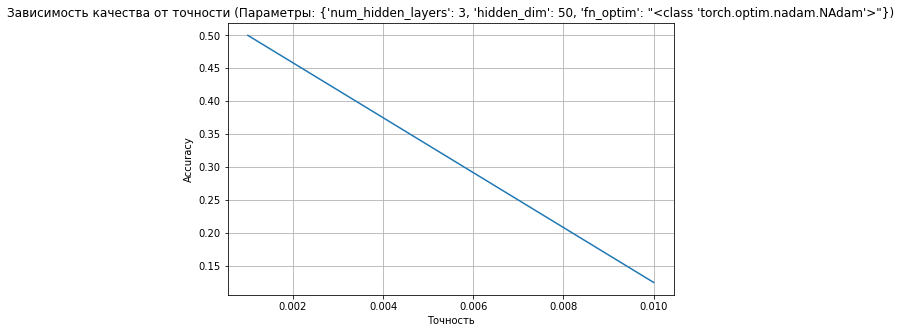

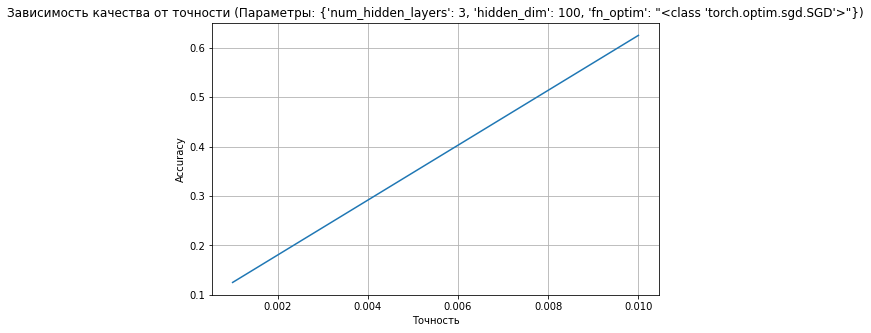

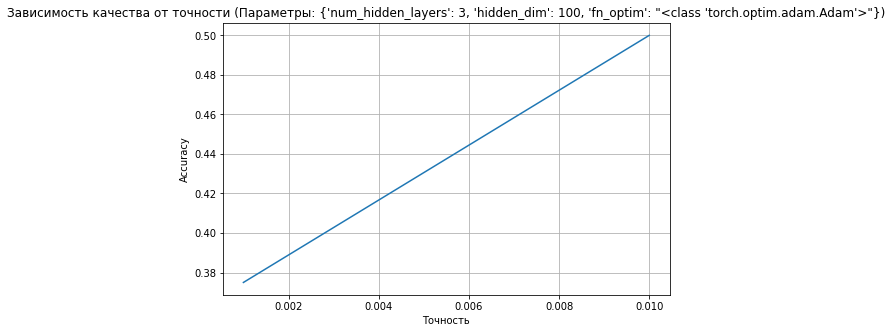

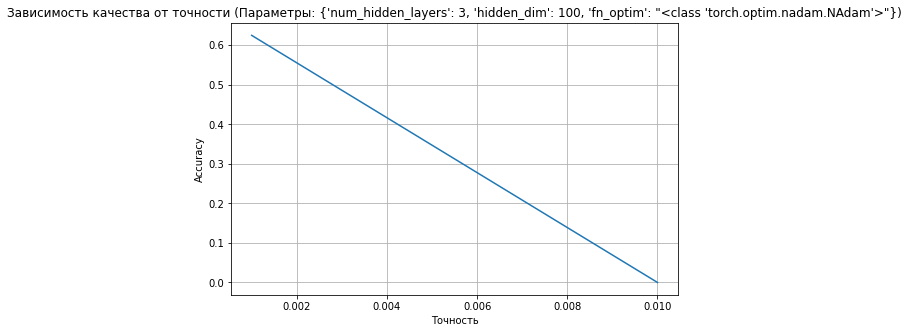

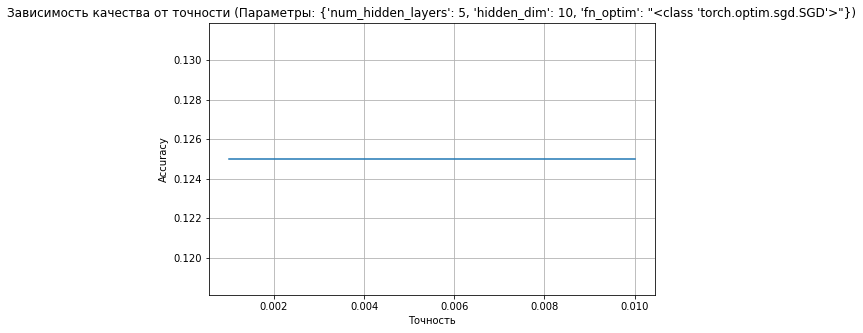

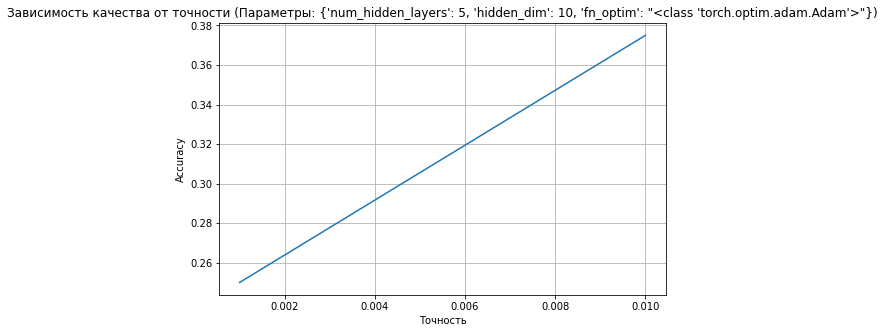

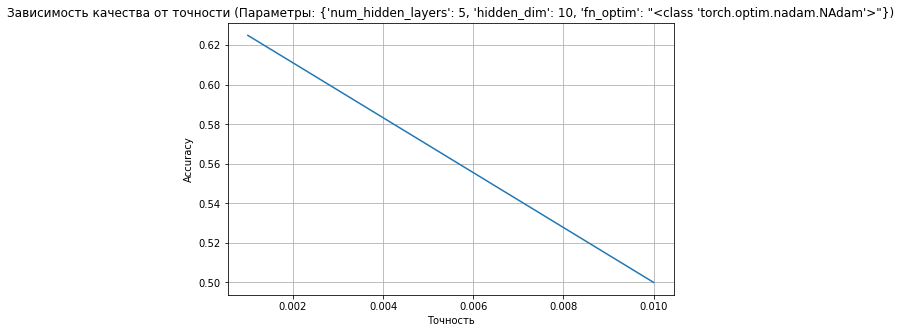

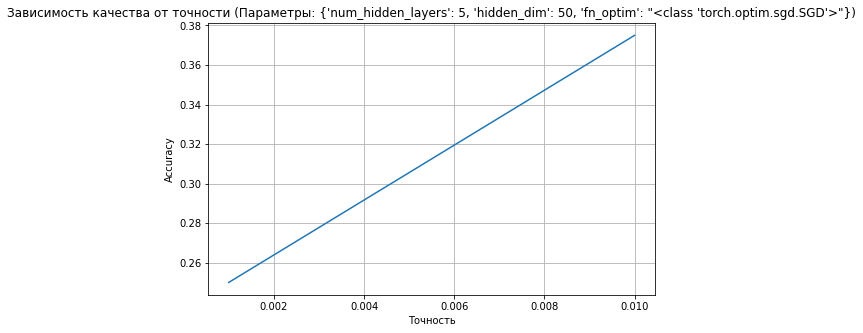

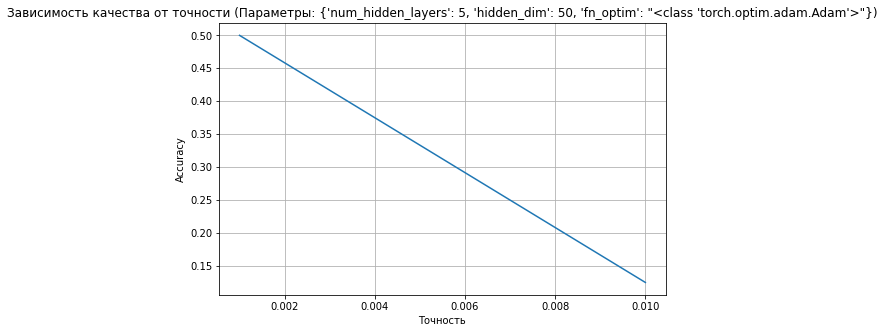

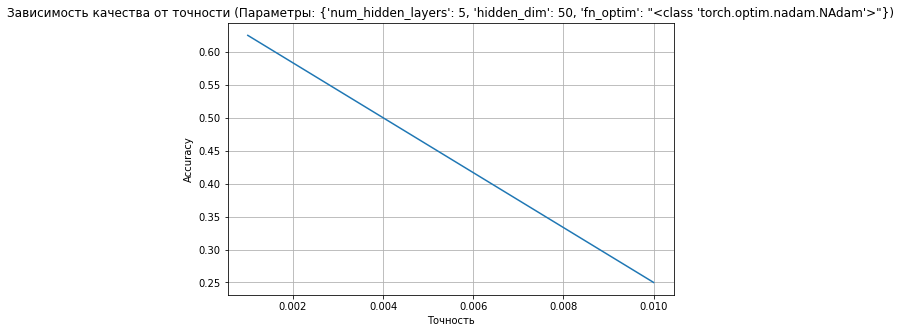

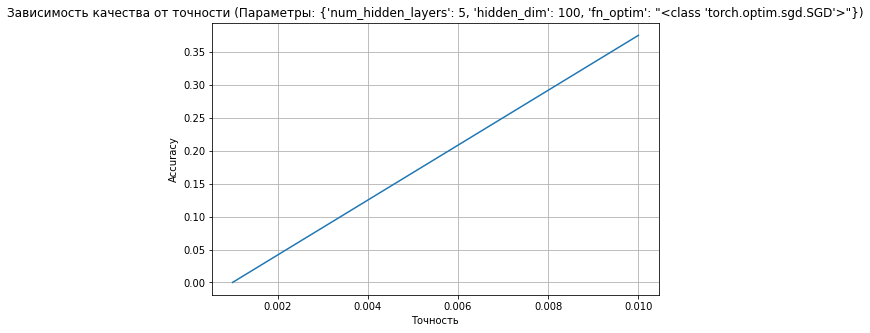

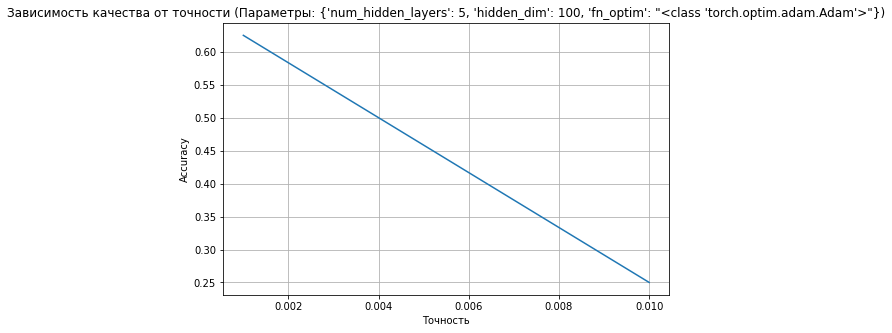

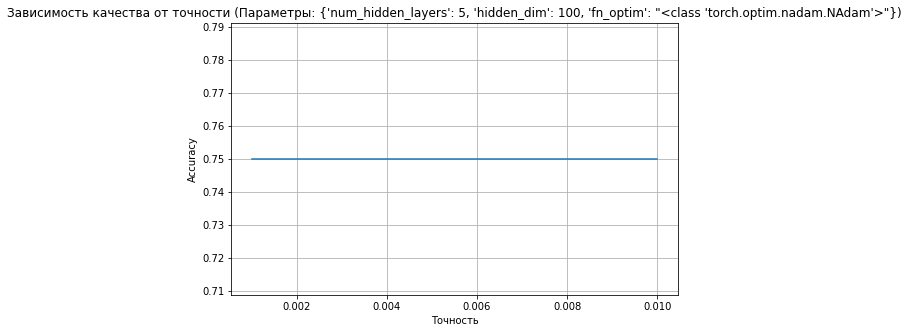

In [79]:
for key in analytics["lr"]:
    lr_analitic = analytics["lr"][key]
    accuracies = lr_analitic["accuracies"]
    params = lr_analitic["params"]
    
    show_graph_by_accuracy(
        accuracies, 
        lrs, 
        "Точность", 
        f"Зависимость качества от точности (Параметры: {params})"
    )